In [ ]:
# Install required packages
!pip install -q numpy matplotlib seaborn pynvml gpustat

# Check GPU
import torch
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PagedAttention vs Traditional Attention Comparison
Initialized comparison for 7B model
KV-cache per token: 0.500 MB
Max sequence length: 2048 tokens
Page size: 16 tokens


1. Single Request Analysis (500 tokens)
----------------------------------------
Traditional Attention:
  • Allocated: 1024.00 MB
  • Used: 250.00 MB
  • Wasted: 774.00 MB (75.6%)

PagedAttention:
  • Allocated: 256.00 MB
  • Used: 250.00 MB
  • Wasted: 6.00 MB (2.3%)

💡 Memory Saved: 768.00 MB (75.0%)

4. Generating visualizations...
----------------------------------------


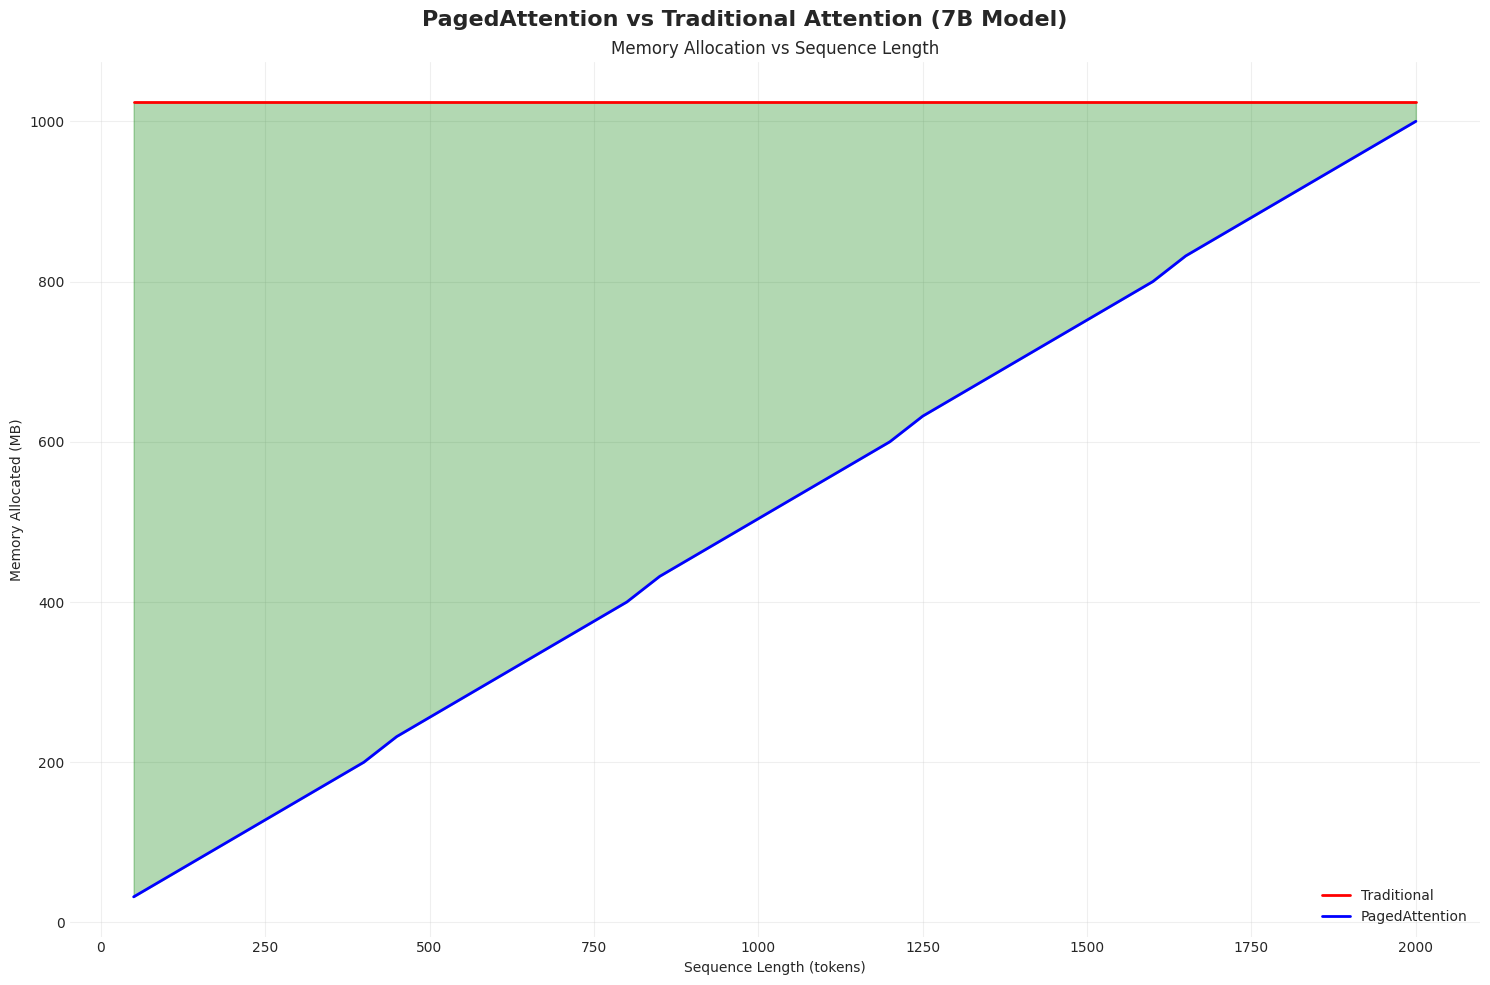


✅ Analysis complete!


In [10]:
"""
Simple and Accurate Comparison: PagedAttention vs Traditional Attention
Focus: Memory allocation patterns and efficiency metrics
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ============================================
# CORE CONFIGURATION
# ============================================

class LLMConfig:
    """Standard LLM configuration"""
    def __init__(self, model_size='7B'):
        configs = {
            '7B': {
                'hidden_dim': 4096,
                'num_layers': 32,
                'num_heads': 32,
            },
            '13B': {
                'hidden_dim': 5120,
                'num_layers': 40,
                'num_heads': 40,
            },
            '70B': {
                'hidden_dim': 8192,
                'num_layers': 80,
                'num_heads': 64,
            }
        }

        self.model_size = model_size
        config = configs[model_size]
        self.hidden_dim = config['hidden_dim']
        self.num_layers = config['num_layers']
        self.num_heads = config['num_heads']

        # Fixed parameters
        self.max_seq_length = 2048  # Standard max sequence length
        self.dtype_bytes = 2  # fp16
        self.page_size = 16  # PagedAttention page size in tokens

    def kv_cache_bytes_per_token(self):
        """Calculate KV-cache size per token in bytes"""
        # For each token: K and V matrices across all layers
        # Size = 2 (K+V) × hidden_dim × num_layers × bytes_per_element
        return 2 * self.hidden_dim * self.num_layers * self.dtype_bytes

    def kv_cache_mb_per_token(self):
        """KV-cache size per token in MB"""
        return self.kv_cache_bytes_per_token() / (1024 * 1024)

# ============================================
# TRADITIONAL ATTENTION
# ============================================

class TraditionalAttention:
    """
    Traditional Attention: Pre-allocates maximum sequence length for every request
    This is how most LLM implementations work without PagedAttention
    """

    def __init__(self, config: LLMConfig):
        self.config = config

    def allocate_request(self, actual_seq_length: int) -> Dict:
        """
        Allocate memory for a single request
        Traditional: Always allocates for max_seq_length regardless of actual length
        """
        # Always allocate maximum possible length
        allocated_tokens = self.config.max_seq_length

        # Calculate memory
        allocated_memory_mb = allocated_tokens * self.config.kv_cache_mb_per_token()
        actual_memory_mb = actual_seq_length * self.config.kv_cache_mb_per_token()
        wasted_memory_mb = allocated_memory_mb - actual_memory_mb

        return {
            'actual_tokens': actual_seq_length,
            'allocated_tokens': allocated_tokens,
            'allocated_memory_mb': allocated_memory_mb,
            'used_memory_mb': actual_memory_mb,
            'wasted_memory_mb': wasted_memory_mb,
            'memory_utilization': (actual_seq_length / allocated_tokens) * 100,
            'waste_percentage': (wasted_memory_mb / allocated_memory_mb) * 100
        }


# ============================================
# PAGED ATTENTION
# ============================================

class PagedAttention:
    """
    PagedAttention: Allocates memory in pages, only as much as needed
    This is vLLM's innovation for efficient memory management
    """

    def __init__(self, config: LLMConfig):
        self.config = config
        self.page_table = {}  # Tracks pages for potential sharing
        self.next_page_id = 0

    def allocate_request(self, actual_seq_length: int, can_share_prefix: bool = False) -> Dict:
        """
        Allocate memory for a single request using paging
        PagedAttention: Only allocates the pages needed for actual length
        """
        # Calculate pages needed (round up)
        pages_needed = (actual_seq_length + self.config.page_size - 1) // self.config.page_size
        allocated_tokens = pages_needed * self.config.page_size

        # Handle prefix sharing (e.g., system prompts)
        shared_pages = 0
        if can_share_prefix and len(self.page_table) > 0:
            # Simulate sharing first few pages (e.g., system prompt)
            shared_pages = min(pages_needed // 3, 10)  # Share up to 1/3 of pages or 10 pages
            pages_needed -= shared_pages

        # Calculate memory
        allocated_memory_mb = allocated_tokens * self.config.kv_cache_mb_per_token()
        actual_memory_mb = actual_seq_length * self.config.kv_cache_mb_per_token()

        # With page sharing, we save memory on shared pages
        if shared_pages > 0:
            saved_memory_mb = shared_pages * self.config.page_size * self.config.kv_cache_mb_per_token()
            allocated_memory_mb -= saved_memory_mb

        wasted_memory_mb = allocated_memory_mb - actual_memory_mb

        # Track pages for sharing
        for _ in range(pages_needed):
            self.page_table[self.next_page_id] = 1
            self.next_page_id += 1

        return {
            'actual_tokens': actual_seq_length,
            'allocated_tokens': allocated_tokens,
            'pages_allocated': pages_needed,
            'pages_shared': shared_pages,
            'allocated_memory_mb': allocated_memory_mb,
            'used_memory_mb': actual_memory_mb,
            'wasted_memory_mb': max(0, wasted_memory_mb),  # Can't be negative
            'memory_utilization': (actual_seq_length / allocated_tokens) * 100 if allocated_tokens > 0 else 100,
            'waste_percentage': (wasted_memory_mb / allocated_memory_mb) * 100 if allocated_memory_mb > 0 else 0
        }

# ============================================
# COMPARISON ENGINE
# ============================================

class AttentionComparison:
    """Simple comparison between Traditional and PagedAttention"""

    def __init__(self, model_size: str = '7B'):
        self.config = LLMConfig(model_size)
        self.traditional = TraditionalAttention(self.config)
        self.paged = PagedAttention(self.config)

        print(f"Initialized comparison for {model_size} model")
        print(f"KV-cache per token: {self.config.kv_cache_mb_per_token():.3f} MB")
        print(f"Max sequence length: {self.config.max_seq_length} tokens")
        print(f"Page size: {self.config.page_size} tokens\n")

    def compare_single_request(self, seq_length: int) -> Dict:
        """Compare allocation for a single request"""
        trad_result = self.traditional.allocate_request(seq_length)
        paged_result = self.paged.allocate_request(seq_length)

        return {
            'sequence_length': seq_length,
            'traditional': trad_result,
            'paged': paged_result,
            'memory_savings_mb': trad_result['allocated_memory_mb'] - paged_result['allocated_memory_mb'],
            'memory_savings_percent': ((trad_result['allocated_memory_mb'] - paged_result['allocated_memory_mb']) /
                                      trad_result['allocated_memory_mb'] * 100)
        }

    def visualize_comparison(self):
        """Create comprehensive visualization"""
        fig, ax1 = plt.subplots(figsize=(15, 10))
        fig.suptitle(f'PagedAttention vs Traditional Attention ({self.config.model_size} Model)',
                     fontsize=16, fontweight='bold')

        # 1. Memory allocation for different sequence lengths
        seq_lengths = list(range(50, 2001, 50))
        trad_memory = []
        paged_memory = []

        for length in seq_lengths:
            result = self.compare_single_request(length)
            trad_memory.append(result['traditional']['allocated_memory_mb'])
            paged_memory.append(result['paged']['allocated_memory_mb'])

        ax1.plot(seq_lengths, trad_memory, 'r-', label='Traditional', linewidth=2)
        ax1.plot(seq_lengths, paged_memory, 'b-', label='PagedAttention', linewidth=2)
        ax1.fill_between(seq_lengths, trad_memory, paged_memory, alpha=0.3, color='green')
        ax1.set_xlabel('Sequence Length (tokens)')
        ax1.set_ylabel('Memory Allocated (MB)')
        ax1.set_title('Memory Allocation vs Sequence Length')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

# ============================================
# MAIN EXECUTION
# ============================================

def main():
    """Run the complete comparison"""
    print("="*60)
    print("PagedAttention vs Traditional Attention Comparison")
    print("="*60)

    # Initialize comparison
    comparison = AttentionComparison(model_size='7B')

    # 1. Single request comparison
    print("\n1. Single Request Analysis (500 tokens)")
    print("-"*40)
    single_result = comparison.compare_single_request(500)

    print(f"Traditional Attention:")
    print(f"  • Allocated: {single_result['traditional']['allocated_memory_mb']:.2f} MB")
    print(f"  • Used: {single_result['traditional']['used_memory_mb']:.2f} MB")
    print(f"  • Wasted: {single_result['traditional']['wasted_memory_mb']:.2f} MB ({single_result['traditional']['waste_percentage']:.1f}%)")

    print(f"\nPagedAttention:")
    print(f"  • Allocated: {single_result['paged']['allocated_memory_mb']:.2f} MB")
    print(f"  • Used: {single_result['paged']['used_memory_mb']:.2f} MB")
    print(f"  • Wasted: {single_result['paged']['wasted_memory_mb']:.2f} MB ({single_result['paged']['waste_percentage']:.1f}%)")

    print(f"\n💡 Memory Saved: {single_result['memory_savings_mb']:.2f} MB ({single_result['memory_savings_percent']:.1f}%)")

    # 4. Generate visualization
    print("\n4. Generating visualizations...")
    print("-"*40)
    fig = comparison.visualize_comparison()
    plt.show()

    print("\n✅ Analysis complete!")

    return comparison

# Run if executed directly
if __name__ == "__main__":
    comparison = main()